In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import folium 
from folium import plugins


In [207]:
plt.rcParams['figure.figsize'] = 10,12

In [208]:
import warnings
warnings.filterwarnings('ignore')

In [291]:
df = pd.read_csv('./macedonia_data.csv')

In [292]:
df

,COUNTRY,COUNTRY_CODE,CONFIRMED,DEATHS,RECOVERED,ACTIVE,DATE
0,"Macedonia, Republic of",MK,0,0,0,0,2020-01-22
1,"Macedonia, Republic of",MK,0,0,0,0,2020-01-23
2,"Macedonia, Republic of",MK,0,0,0,0,2020-01-24
3,"Macedonia, Republic of",MK,0,0,0,0,2020-01-25
4,"Macedonia, Republic of",MK,0,0,0,0,2020-01-26
...,...,...,...,...,...,...,...
217,"Macedonia, Republic of",MK,13914,578,10507,2829,2020-08-26
218,"Macedonia, Republic of",MK,14004,585,10722,2697,2020-08-27
219,"Macedonia, Republic of",MK,14163,590,10933,2640,2020-08-28
220,"Macedonia, Republic of",MK,14293,596,11014,2683,2020-08-29


In [293]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222 entries, 0 to 221
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   COUNTRY       222 non-null    object
 1   COUNTRY_CODE  222 non-null    object
 2   CONFIRMED     222 non-null    int64 
 3   DEATHS        222 non-null    int64 
 4   RECOVERED     222 non-null    int64 
 5   ACTIVE        222 non-null    int64 
 6   DATE          222 non-null    object
dtypes: int64(4), object(3)
memory usage: 12.3+ KB


In [297]:
df['DAILY NEW CASES'] = df['CONFIRMED'] - df['CONFIRMED'].shift(1)
df['DAILY NEW DEATHS'] = df['DEATHS'] - df['DEATHS'].shift(1)
df['DAILY CURED'] = df['RECOVERED'] - df['RECOVERED'].shift(1)

In [298]:
df

,COUNTRY,COUNTRY_CODE,CONFIRMED,DEATHS,RECOVERED,ACTIVE,DATE,DAILY NEW CASES,DAILY NEW DEATHS,DAILY CURED
0,"Macedonia, Republic of",MK,0,0,0,0,2020-01-22,NaN,NaN,NaN
1,"Macedonia, Republic of",MK,0,0,0,0,2020-01-23,0.0,0.0,0.0
2,"Macedonia, Republic of",MK,0,0,0,0,2020-01-24,0.0,0.0,0.0
3,"Macedonia, Republic of",MK,0,0,0,0,2020-01-25,0.0,0.0,0.0
4,"Macedonia, Republic of",MK,0,0,0,0,2020-01-26,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
217,"Macedonia, Republic of",MK,13914,578,10507,2829,2020-08-26,115.0,5.0,297.0
218,"Macedonia, Republic of",MK,14004,585,10722,2697,2020-08-27,90.0,7.0,215.0
219,"Macedonia, Republic of",MK,14163,590,10933,2640,2020-08-28,159.0,5.0,211.0
220,"Macedonia, Republic of",MK,14293,596,11014,2683,2020-08-29,130.0,6.0,81.0


In [302]:
df['DAILY NEW CASES'] = df['DAILY NEW CASES'].fillna(0)
df['DAILY NEW DEATHS'] = df['DAILY NEW DEATHS'].fillna(0)
df['DAILY CURED'] = df['DAILY CURED'].fillna(0)
df

,COUNTRY,COUNTRY_CODE,CONFIRMED,DEATHS,RECOVERED,ACTIVE,DATE,DAILY NEW CASES,DAILY NEW DEATHS,DAILY CURED
0,"Macedonia, Republic of",MK,0,0,0,0,2020-01-22,0.0,0.0,0.0
1,"Macedonia, Republic of",MK,0,0,0,0,2020-01-23,0.0,0.0,0.0
2,"Macedonia, Republic of",MK,0,0,0,0,2020-01-24,0.0,0.0,0.0
3,"Macedonia, Republic of",MK,0,0,0,0,2020-01-25,0.0,0.0,0.0
4,"Macedonia, Republic of",MK,0,0,0,0,2020-01-26,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
217,"Macedonia, Republic of",MK,13914,578,10507,2829,2020-08-26,115.0,5.0,297.0
218,"Macedonia, Republic of",MK,14004,585,10722,2697,2020-08-27,90.0,7.0,215.0
219,"Macedonia, Republic of",MK,14163,590,10933,2640,2020-08-28,159.0,5.0,211.0
220,"Macedonia, Republic of",MK,14293,596,11014,2683,2020-08-29,130.0,6.0,81.0


In [304]:
df['DATE'] = pd.to_datetime(df['DATE'])
total_per_month_df = df.groupby(df['DATE'].dt.strftime('%B'))['DAILY NEW CASES'].sum().sort_values(ascending=False).to_frame()


In [305]:
total_per_month_df.style.background_gradient(cmap='Reds')

,DAILY NEW CASES
DATE,
July,4420.000000
June,4108.000000
August,3576.000000
April,1136.000000
May,761.000000
March,328.000000
February,1.000000
January,0.000000


In [306]:
total_per_month_df = df.groupby(df['DATE'].rename("MONTH").dt.strftime('%B')).agg(
TOTAL_CASES = pd.NamedAgg(column='DAILY NEW CASES', aggfunc=sum),
TOTAL_DEATHS = pd.NamedAgg(column='DAILY NEW DEATHS', aggfunc=sum),
TOTAL_CURED = pd.NamedAgg(column='DAILY CURED', aggfunc=sum),
)

In [307]:
total_per_month_df

,TOTAL_CASES,TOTAL_DEATHS,TOTAL_CURED
MONTH,,,
April,1136.0,68.0,726.0
August,3576.0,114.0,4508.0
February,1.0,0.0,0.0
January,0.0,0.0,0.0
July,4420.0,184.0,4079.0
June,4108.0,169.0,923.0
March,328.0,9.0,12.0
May,761.0,56.0,814.0


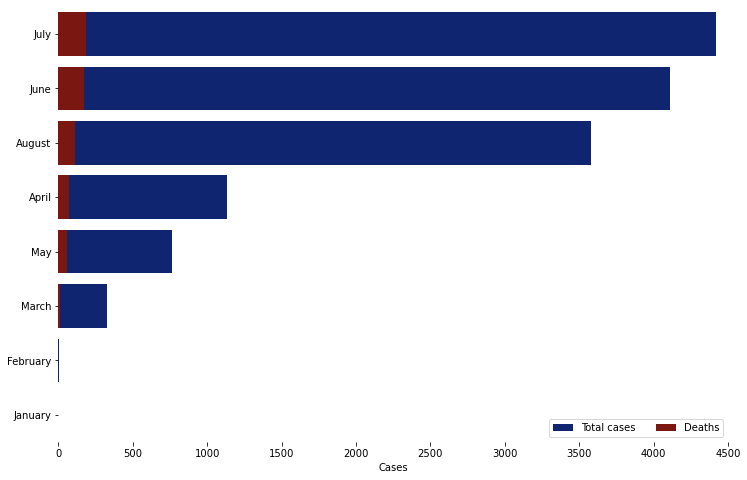

In [217]:
f, ax = plt.subplots(figsize = (12,8))
data = total_per_month_df.copy()
data['MONTH'] = data.index
data.sort_values('TOTAL_CASES', ascending =  False, inplace = True)
sns.set_color_codes("dark")
sns.barplot(x = "TOTAL_CASES", y = "MONTH", data = data, label = "Total cases", color = "b")
sns.set_color_codes("dark")
sns.barplot(x = "TOTAL_DEATHS", y = "MONTH", data = data, label = "Deaths", color = "r")

ax.legend(ncol = 2, loc = "lower right", frameon = True)
ax.set(xlim = (0, 4500), ylabel = "", xlabel="Cases")
sns.despine(left = True, bottom = True)


In [308]:
import plotly
plotly.io.renderers.default = 'browser'

In [309]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['DATE'], y=df['DAILY NEW CASES'], mode='lines+markers', name='Total Cases'))
fig.update_layout(title_text='Coronavirus cases in North Macedonia', plot_bgcolor='rgb(230,230,230)')
fig.show()




In [310]:
import plotly.express as px
fig = px.bar(df, x="DATE", y= "DAILY NEW CASES", barmode='group', height = 400)
fig.update_layout(title_text='Coronavirus cases in North Macedonia', plot_bgcolor='rgb(230,230,230)')
fig.show()

In [353]:
df_italy = pd.read_csv('./italy.csv')
df_spain = pd.read_csv('./spain.csv')

In [354]:
df_italy['DATE'] = pd.to_datetime(df_italy['DATE'])
df_spain['DATE'] = pd.to_datetime(df_spain['DATE'])

In [355]:
df_italy['DAILY NEW CASES'] = df_italy['CONFIRMED'] - df_italy['CONFIRMED'].shift(1)
df_italy['DAILY NEW DEATHS'] = df_italy['DEATHS'] - df_italy['DEATHS'].shift(1)
df_italy['DAILY CURED'] = df_italy['RECOVERED'] - df_italy['RECOVERED'].shift(1)

In [356]:
df_italy['DAILY NEW CASES'] = df_italy['DAILY NEW CASES'].fillna(0)
df_italy['DAILY NEW DEATHS'] = df_italy['DAILY NEW DEATHS'].fillna(0)
df_italy['DAILY CURED'] = df_italy['DAILY CURED'].fillna(0)
df_italy

,COUNTRY,COUNTRY_CODE,CONFIRMED,DEATHS,RECOVERED,ACTIVE,DATE,DAILY NEW CASES,DAILY NEW DEATHS,DAILY CURED
0,Italy,IT,0,0,0,0,2020-01-22,0.0,0.0,0.0
1,Italy,IT,0,0,0,0,2020-01-23,0.0,0.0,0.0
2,Italy,IT,0,0,0,0,2020-01-24,0.0,0.0,0.0
3,Italy,IT,0,0,0,0,2020-01-25,0.0,0.0,0.0
4,Italy,IT,0,0,0,0,2020-01-26,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
217,Italy,IT,262540,35458,206329,20753,2020-08-26,1366.0,13.0,314.0
218,Italy,IT,263949,35463,206554,21932,2020-08-27,1409.0,5.0,225.0
219,Italy,IT,265409,35472,206902,23035,2020-08-28,1460.0,9.0,348.0
220,Italy,IT,266853,35473,208224,23156,2020-08-29,1444.0,1.0,1322.0


In [357]:
df_spain['DAILY NEW CASES'] = df_spain['CONFIRMED'] - df_spain['CONFIRMED'].shift(1)
df_spain['DAILY NEW DEATHS'] = df_spain['DEATHS'] - df_spain['DEATHS'].shift(1)
df_spain['DAILY CURED'] = df_spain['RECOVERED'] - df_spain['RECOVERED'].shift(1)

In [360]:
df_spain['DAILY NEW CASES'] = df_spain['DAILY NEW CASES'].fillna(0)
df_spain['DAILY NEW DEATHS'] = df_spain['DAILY NEW DEATHS'].fillna(0)
df_spain['DAILY CURED'] = df_spain['DAILY CURED'].fillna(0)
df_spain
mean = df_spain["DAILY NEW CASES"].mean()
df_spain[df_spain['DAILY NEW CASES'] < 0] = mean
df_spain
       

,COUNTRY,COUNTRY_CODE,CONFIRMED,DEATHS,RECOVERED,ACTIVE,DATE,DAILY NEW CASES,DAILY NEW DEATHS,DAILY CURED
0,Spain,ES,0.0,0.0,0.0,0.0,2020-01-22 00:00:00,0.0,0.0,0.0
1,Spain,ES,0.0,0.0,0.0,0.0,2020-01-23 00:00:00,0.0,0.0,0.0
2,Spain,ES,0.0,0.0,0.0,0.0,2020-01-24 00:00:00,0.0,0.0,0.0
3,Spain,ES,0.0,0.0,0.0,0.0,2020-01-25 00:00:00,0.0,0.0,0.0
4,Spain,ES,0.0,0.0,0.0,0.0,2020-01-26 00:00:00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
217,Spain,ES,419849.0,28971.0,150376.0,240502.0,2020-08-26 00:00:00,7296.0,47.0,0.0
218,Spain,ES,429507.0,28996.0,150376.0,250135.0,2020-08-27 00:00:00,9658.0,25.0,0.0
219,Spain,ES,439286.0,29011.0,150376.0,259899.0,2020-08-28 00:00:00,9779.0,15.0,0.0
220,Spain,ES,439286.0,29011.0,150376.0,259899.0,2020-08-29 00:00:00,0.0,0.0,0.0


In [361]:
from plotly.subplots import make_subplots

fig = make_subplots(
rows = 2, cols =2,
specs= [[{},{}],
        [{"colspan": 2}, None]],
subplot_titles=("North Macedonia", "Italy", "Spain"))

fig.add_trace(go.Bar(x=df['DATE'], \
                     y = df['DAILY NEW CASES'], \
                     marker = dict(color = df['DAILY NEW CASES'], \
                                   coloraxis="coloraxis")), row=1 , col=1)

fig.add_trace(go.Bar(x=df_italy['DATE'], \
                     y = df_italy['DAILY NEW CASES'], \
                     marker = dict(color = df_italy['DAILY NEW CASES'], \
                                   coloraxis="coloraxis")), row=1 , col=2)

fig.add_trace(go.Bar(x=df_spain['DATE'], \
                     y = df_spain['DAILY NEW CASES'], \
                     marker = dict(color = df_spain['DAILY NEW CASES'], \
                                   coloraxis="coloraxis")), row=2, col=1)

fig.update_layout(coloraxis=dict(colorscale = 'Bluered_r'), showlegend = False)

fig.update_layout(plot_bgcolor='rgb(230,230,230)')

fig.show()

In [253]:
maxNum = 0
for item in df['DAILY NEW CASES']

240.0


In [273]:
from fbprophet import Prophet

In [274]:
confirmed = df.groupby('DATE').sum()['DAILY NEW CASES'].reset_index()
deaths = df.groupby('DATE').sum()['DAILY NEW CASES'].reset_index()
recovered = df.groupby('DATE').sum()['DAILY NEW CASES'].reset_index()

In [275]:
confirmed

,DATE,DAILY NEW CASES
0,2020-01-22,0.0
1,2020-01-23,0.0
2,2020-01-24,0.0
3,2020-01-25,0.0
4,2020-01-26,0.0
...,...,...
217,2020-08-26,115.0
218,2020-08-27,90.0
219,2020-08-28,159.0
220,2020-08-29,130.0


In [276]:
confirmed.columns = ['ds', 'y']

In [278]:
confirmed['ds'] = pd.to_datetime(confirmed['ds'])

In [279]:
confirmed

,ds,y
0,2020-01-22,0.0
1,2020-01-23,0.0
2,2020-01-24,0.0
3,2020-01-25,0.0
4,2020-01-26,0.0
...,...,...
217,2020-08-26,115.0
218,2020-08-27,90.0
219,2020-08-28,159.0
220,2020-08-29,130.0


In [288]:
m = Prophet(interval_width = 0.95)
m.fit(confirmed)
future = m.make_future_dataframe(periods=6)
future.tail()


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
223,2020-09-01
224,2020-09-02
225,2020-09-03
226,2020-09-04
227,2020-09-05


In [289]:
forecast = m.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
223,2020-09-01,140.430908,78.732606,208.980983
224,2020-09-02,150.308958,85.378025,224.069519
225,2020-09-03,153.609583,90.687122,223.281053
226,2020-09-04,159.883239,96.336938,226.119195
227,2020-09-05,163.126309,97.863804,227.495290
